Import Libraries

In [7]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.filters import gaussian, threshold_otsu, threshold_multiotsu
from skimage.morphology import remove_small_objects, disk, binary_closing
from scipy.ndimage import zoom, binary_dilation
from skimage.measure import label, regionprops
from skimage import io, exposure
from skimage import measure
from skimage import exposure
from czifile import imread
from cellpose import models, plot 
model = models.Cellpose(gpu=False, model_type='cyto3')

c:\Users\sj1205\AppData\Local\Programs\Python\Python312\Lib\site-packages\cellpose\resnet_torch.py:275: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load

Define Sub Functions

In [8]:
def display_image(image, path, type):
    """Display the image."""
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"{path} {type}")
    plt.show()

def extract_image_paths(folder):
    """Extract all image file paths from the specified folder."""
    return [os.path.join(folder, f) for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]

def read_image(image_path):
    """Read the LSM image from the specified path."""
    return imread(image_path)

def otsu_thresholding_c12(channel):
    """Apply Otsu's thresholding to the channel."""
    threshold_value = threshold_otsu(channel)
    #print(threshold_value)
    #disappearing_value = 1200
    valid = True
    #if threshold_value < disappearing_value:
    #    #threshold_value = disappearing_value
    #    valid = False
    binary_image = channel > threshold_value
    return binary_image, valid

def otsu_thresholding_deep_red(channel):
    """Apply Otsu's thresholding to the channel."""
    threshold_value = threshold_otsu(channel)
    #print(threshold_value)
    disappearing_value = 3200
    valid = True
    if threshold_value < disappearing_value:
        threshold_value = disappearing_value
        valid = False
    binary_image = channel > threshold_value
    return binary_image, valid

def extract_channels(image):
    return image[0], image[1], image[2]

def analyze_image_c12(c12):
    binary_image, valid = otsu_thresholding_c12(c12)
    #if valid == False:
    #    print(f"bleedthrough detected {image_path}") 
    #display_image(binary_image, image_path, "c12")
    labled_image = label(binary_image)
    return labled_image

def analyze_image_deep_red(deep_red):
    binary_image, valid = otsu_thresholding_deep_red(deep_red)
    #if valid == False:
    #    print(f"bleedthrough detected {image_path}") 
    #display_image(binary_image, image_path, "deep red")
    labled_image = label(binary_image)
    return labled_image

def deep_red_only(red_mask, c12_mask, dilation_size=15):
    """
    Generate a mask containing only the red regions (mask1), excluding adjacent c12 regions.
    The adjacency boundary is expanded using binary dilation.
    """
    # Create a mask of red-only areas by excluding c12 regions
    new_red_mask = np.logical_and(red_mask, np.logical_not(c12_mask))  # Red only
    
    # Check for adjacent pixels between red and c12 regions (boundary detection)
    boundary_mask = np.logical_and(new_red_mask, np.roll(c12_mask, 1, axis=0)) | \
                    np.logical_and(new_red_mask, np.roll(c12_mask, -1, axis=0)) | \
                    np.logical_and(new_red_mask, np.roll(c12_mask, 1, axis=1)) | \
                    np.logical_and(new_red_mask, np.roll(c12_mask, -1, axis=1))
    
    # Apply binary dilation to the boundary mask to expand the boundary
    dilated_boundary = binary_dilation(boundary_mask, structure=np.ones((dilation_size, dilation_size)))  # Expands boundary
    
    # Remove the expanded boundary areas from the red mask
    new_red_mask_clean = np.logical_and(new_red_mask, np.logical_not(dilated_boundary))
    
    # Label the regions in the cleaned red mask
    label_image = label(new_red_mask_clean)
    return label_image

def c12_only(deep_red_mask, c12_mask, dilation_size=15):
    """
    Generate a mask containing only the c12 regions (mask2), excluding adjacent red regions.
    The adjacency boundary is expanded using binary dilation.
    """
    # Create a mask of c12-only areas by excluding deep red regions
    new_c12_mask = np.logical_and(np.logical_not(deep_red_mask), c12_mask)  # C12 only
    
    # Check for adjacent pixels between c12 and red regions (boundary detection)
    boundary_mask = np.logical_and(new_c12_mask, np.roll(deep_red_mask, 1, axis=0)) | \
                    np.logical_and(new_c12_mask, np.roll(deep_red_mask, -1, axis=0)) | \
                    np.logical_and(new_c12_mask, np.roll(deep_red_mask, 1, axis=1)) | \
                    np.logical_and(new_c12_mask, np.roll(deep_red_mask, -1, axis=1))
    
    # Apply binary dilation to the boundary mask to expand the boundary
    dilated_boundary = binary_dilation(boundary_mask, structure=np.ones((dilation_size, dilation_size)))  # Expands boundary
    
    # Remove the expanded boundary areas from the c12 mask
    new_c12_mask_clean = np.logical_and(new_c12_mask, np.logical_not(dilated_boundary))
    
    # Label the regions in the cleaned c12 mask
    label_image = label(new_c12_mask_clean)
    return label_image

def calculate_surface_area(labeled_image):
    """Calculate the total surface area for labeled regions."""
    props = regionprops(labeled_image)
    return sum(prop.area for prop in props)


def circularity_index(image):

    regions = measure.regionprops(image)
    i=0
    p=0
    # Loop through each region and calculate circularity
    for region in regions:
        area = region.area
        perimeter = measure.perimeter(region.image)  # Calculate perimeter for the region
        if perimeter == 0:
            continue
        circularity = (4 * np.pi * area) / (perimeter ** 2)
        
        if circularity < 0.65:
            # do stuff for clustered regions 
            i+=1
        else:
            p +=1
    print(f"{i} and {p}")

def cell_pose(channel, path, red_total, c12_total):
    bright_image = exposure.adjust_gamma(channel, gamma=0.5)  # Gamma < 1 makes it brighter
    masks, flows, styles, diams = model.eval(bright_image, diameter=280, channels=[0, 0])
    labeled_cells = label(masks)
    
    cell_data = []

    filtered_cells = [cell for cell in regionprops(labeled_cells) if cell.area >= 100]

    for i, cell in enumerate(filtered_cells):
        mask = labeled_cells == cell.label
        applied_mask = gaussian(channel) * mask
        threshold = 0.4
        inclusions = applied_mask > threshold
        inclusions_labeled = label(inclusions)

        swiss_or_solid = []  # Track types of inclusions
        inclusion_size = []
        inclusion_size_swiss = []
        inclusion_size_solid = []



        #if (len(inclusion_areas) > 0):
        #    display_image(inclusions_labeled, path, i+1)

        applied_mask = applied_mask > 0  # Convert to boolean if not already
        red_total = red_total > 0  # Convert to boolean if not already
        c12_total = c12_total > 0  # Convert to boolean if not already

        Red_LDS_in_cell = (applied_mask & red_total) 
        C12_LDS_in_cell = (applied_mask & c12_total)

        if np.any(C12_LDS_in_cell):
            C12_LDS_labeled = label(C12_LDS_in_cell)
            total_surface_area_C12_LDS = calculate_surface_area(C12_LDS_labeled)
            total_C12_LDS = len(regionprops(C12_LDS_labeled))

            #display_image(C12_LDS_labeled, path, i+1)

            #print(f"Cell {i + 1} has {total_C12_LDS} C12 LDS")
        
        if np.any(Red_LDS_in_cell):
            Red_LDS_labeled = label(Red_LDS_in_cell)

            total_Red_LDS = len(regionprops(Red_LDS_labeled))

            #display_image(Red_LDS_labeled, path, i+1)

            #print(f"Cell {i + 1} has {total_Red_LDS} Red LDS")

        
        for inclusion in regionprops(inclusions_labeled):
            if inclusion.area > 10:
                inclusion_mask = inclusions_labeled == inclusion.label
                LDS_in_inclusion = (inclusion_mask & red_total) | (inclusion_mask & c12_total)
                inclusion_size.append(inclusion.area)

                C12_LDS_in_inclusion = (inclusion_mask & c12_total)
                C12_LDS_not_in_inclusion = np.logical_not(C12_LDS_in_inclusion)
                display_image(C12_LDS_in_inclusion, path, i+1)
                display_image(C12_LDS_not_in_inclusion, path, i+1)

                # Determine inclusion type based on lipid presence
                if np.any(LDS_in_inclusion):
                    inclusion_size_swiss.append(inclusion.area)
                    type = "swiss"
                else:
                    inclusion_size_solid.append(inclusion.area)
                    type = "solid"
                print(f"{inclusion.area} {type} inclusion in cell {cell.label}")

        if not inclusion_size:
            cell_data.append({
                'Filename': path,
                'Cell Number': i + 1,
                'Cytoplasm Surface Area': cell.area,
                'Total Number of Inclusions': None,  # No inclusion number
                'Average of Total Inclusion Surface Area': 0,  # No inclusion surface area
                'Number of Solid Inclusions': 0,
                'Average Solid Inclusion Surface Area': 0,  # Average surface area of solid inclusions
                'Number of Swiss Inclusions': 0,
                'Average Swiss Inclusion Surface Area': 0,  # Surface area of this inclusion
                'Number of C12 Total LDS': total_C12_LDS,
                'Surface area of C12 Total LDS': total_surface_area_C12_LDS,

            })
        else:
            total_inclusions = len(inclusion_size)  # Total number of inclusions
            average_surface_area = sum(inclusion_size) / total_inclusions  # Average surface area

            number_of_solid_inclusions = len(inclusion_size_solid)  

            if number_of_solid_inclusions == 0:
                average_surface_area_solid = 0
            else: 
                average_surface_area_solid = sum(inclusion_size_solid) / number_of_solid_inclusions

            number_of_swiss_inclusions = len(inclusion_size_swiss) 

            if number_of_swiss_inclusions == 0:
                average_surface_area_swiss = 0
            else:
                # Avoid division by zero for average surface area of swiss inclusions
                average_surface_area_swiss = sum(inclusion_size_swiss) / number_of_swiss_inclusions

            cell_data.append({
                'Filename': path,
                'Cell Number': i + 1,
                'Cytoplasm Surface Area': cell.area,
                'Total Number of Inclusions': total_inclusions, 
                'Average of Total Inclusion Surface Area': average_surface_area,  # Average surface area of inclusions
                'Number of Solid Inclusions': number_of_solid_inclusions,
                'Average Solid Inclusion Surface Area': average_surface_area_solid,  # Average surface area of solid inclusions
                'Number of Swiss Inclusions': number_of_swiss_inclusions,
                'Average Swiss Inclusion Surface Area': average_surface_area_swiss,  # Surface area of this inclusion
                'Number of C12 Total LDS': total_C12_LDS,
                'Surface area of C12 Total LDS': total_surface_area_C12_LDS,
            })
    df_cell_summary = pd.DataFrame(cell_data)

    return df_cell_summary

Main Function

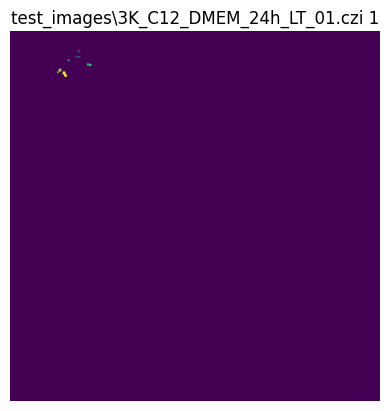

Cell 1 has 6 C12 LDS


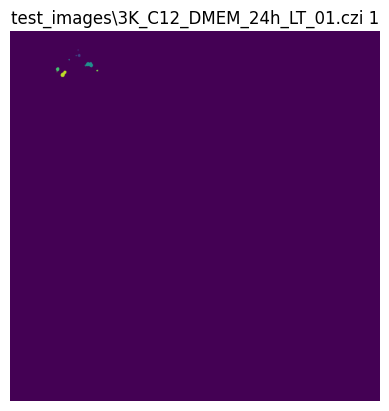

Cell 1 has 10 Red LDS


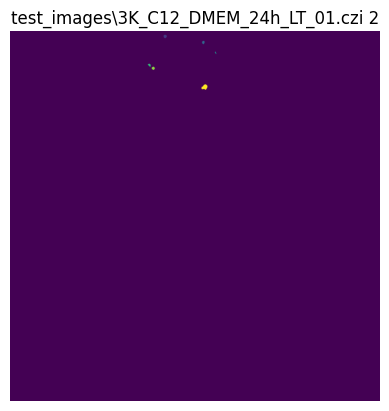

Cell 2 has 6 C12 LDS


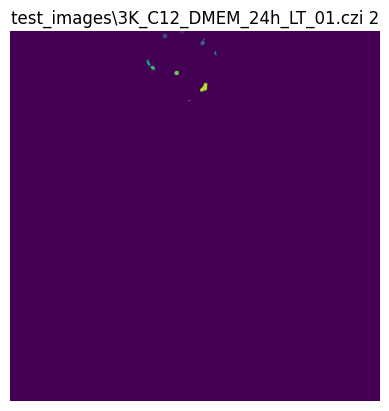

Cell 2 has 9 Red LDS


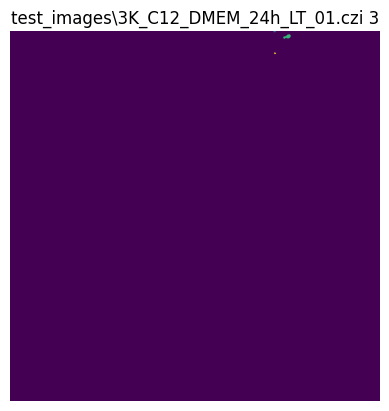

Cell 3 has 3 C12 LDS


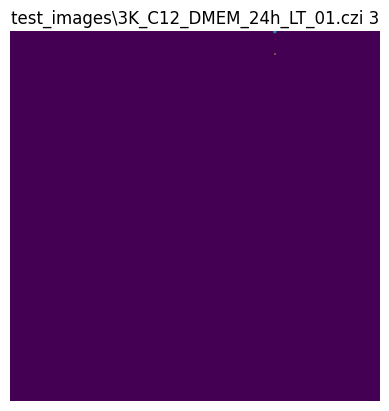

Cell 3 has 2 Red LDS


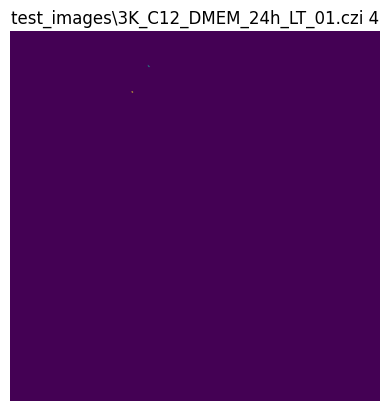

Cell 4 has 2 C12 LDS


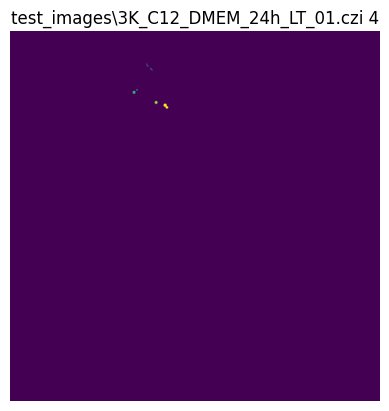

Cell 4 has 6 Red LDS


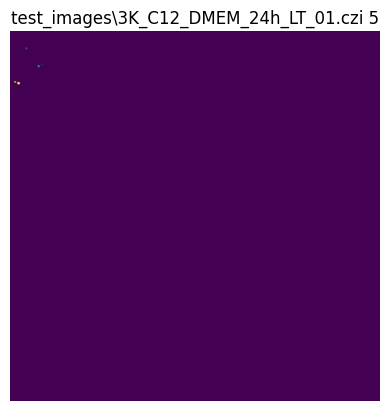

Cell 5 has 5 C12 LDS


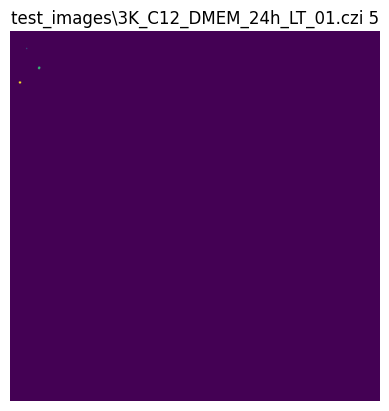

Cell 5 has 3 Red LDS
60.0 solid inclusion in cell 7


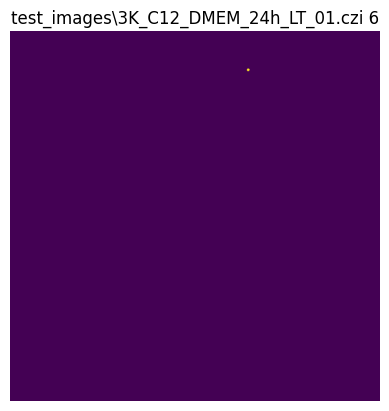

Cell 6 has 1 C12 LDS


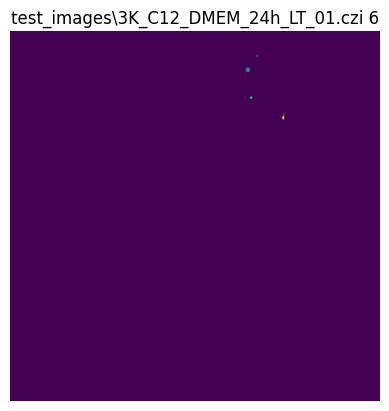

Cell 6 has 4 Red LDS


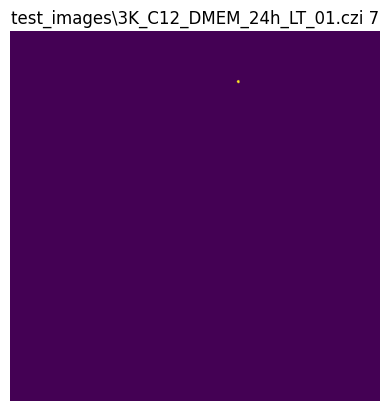

Cell 7 has 1 C12 LDS


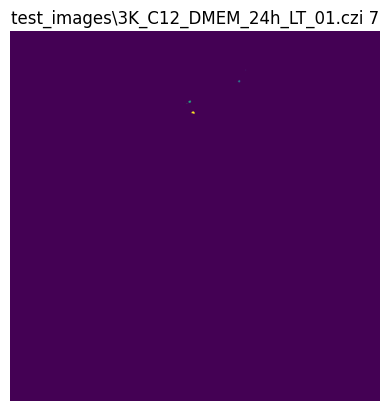

Cell 7 has 5 Red LDS


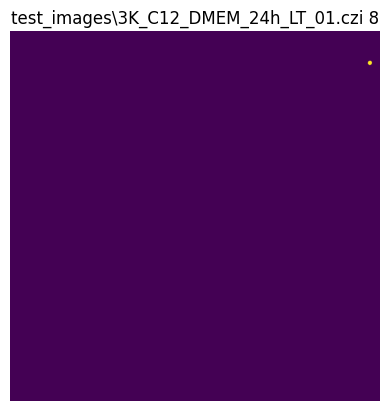

Cell 8 has 1 C12 LDS


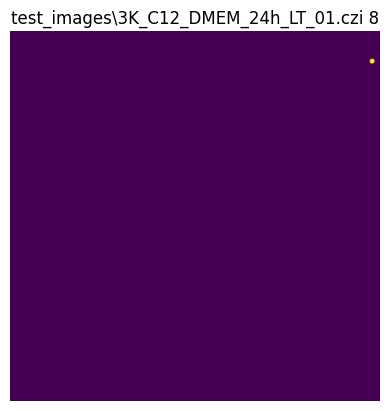

Cell 8 has 1 Red LDS


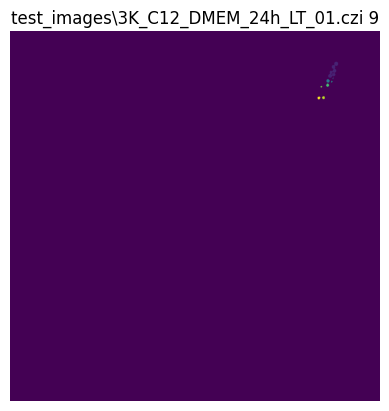

Cell 9 has 10 C12 LDS


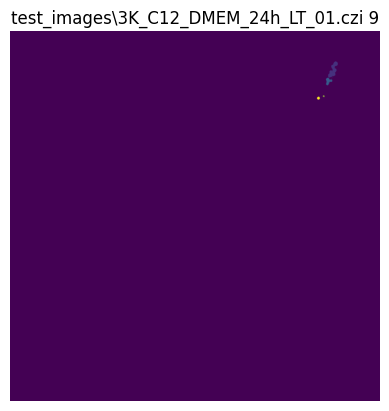

Cell 9 has 7 Red LDS


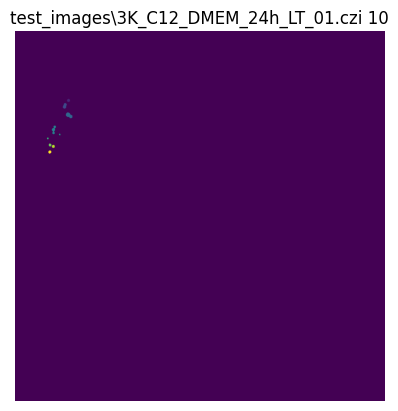

Cell 10 has 9 C12 LDS


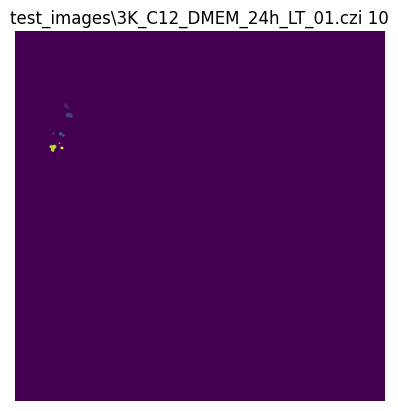

Cell 10 has 10 Red LDS


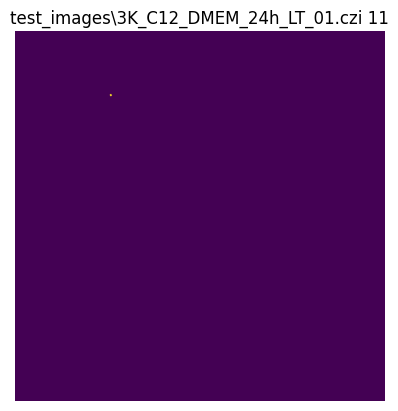

Cell 11 has 1 Red LDS


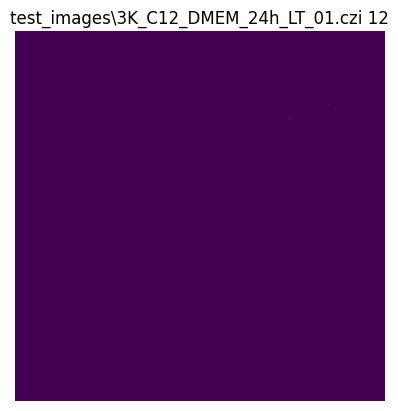

Cell 12 has 2 C12 LDS


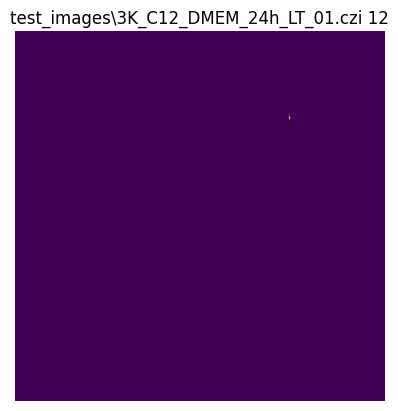

Cell 12 has 3 Red LDS


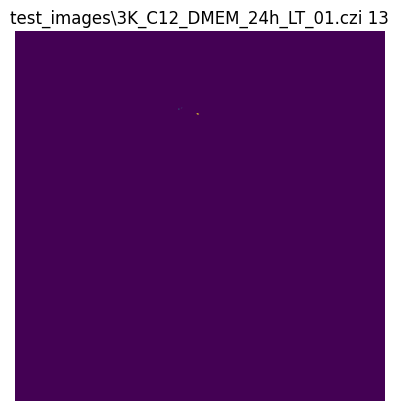

Cell 13 has 4 Red LDS


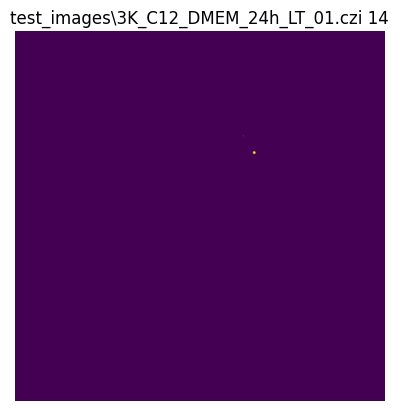

Cell 14 has 3 C12 LDS


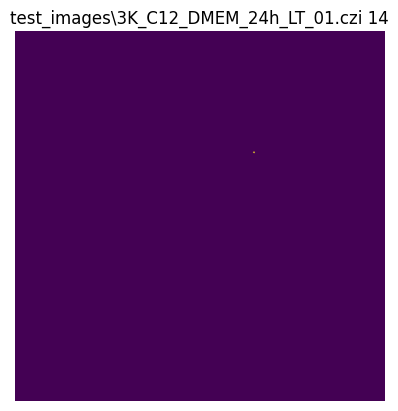

Cell 14 has 1 Red LDS


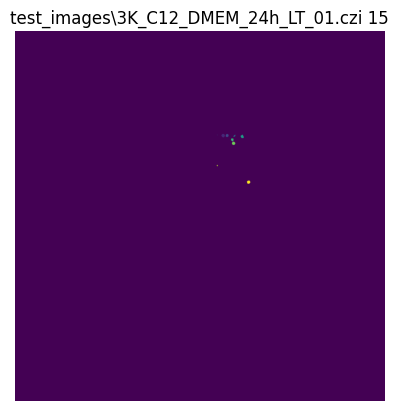

Cell 15 has 9 C12 LDS


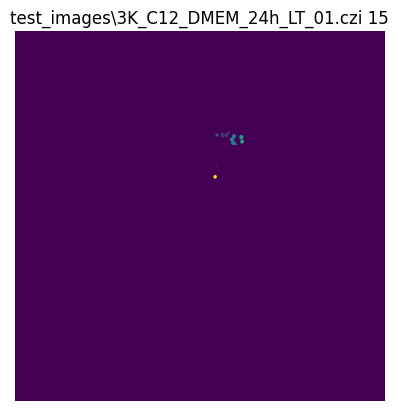

Cell 15 has 7 Red LDS


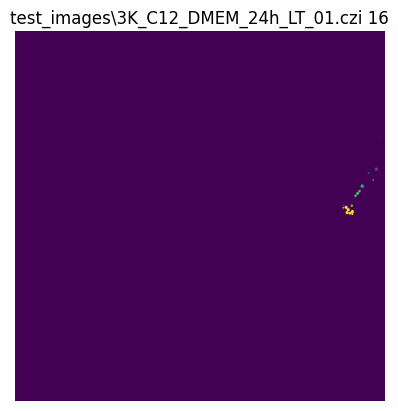

Cell 16 has 10 C12 LDS


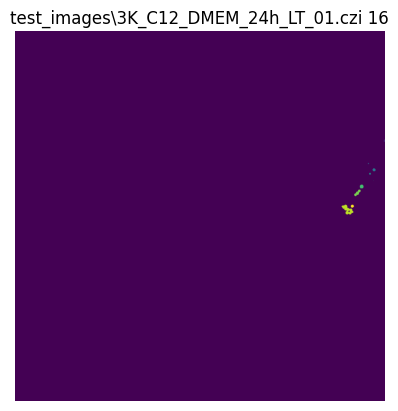

Cell 16 has 10 Red LDS
16.0 solid inclusion in cell 23
27.0 solid inclusion in cell 23


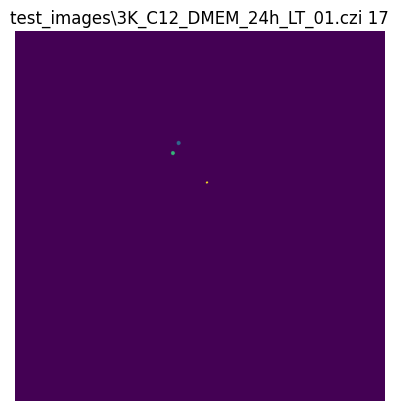

Cell 17 has 3 C12 LDS


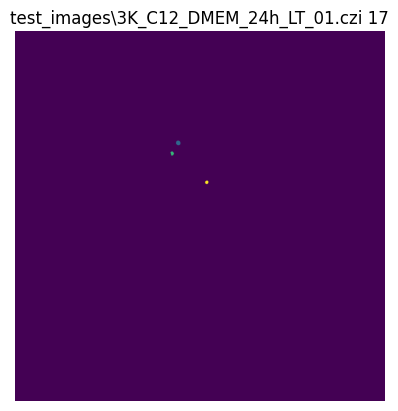

Cell 17 has 3 Red LDS


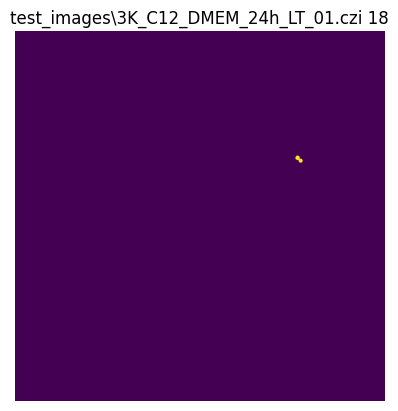

Cell 18 has 1 C12 LDS


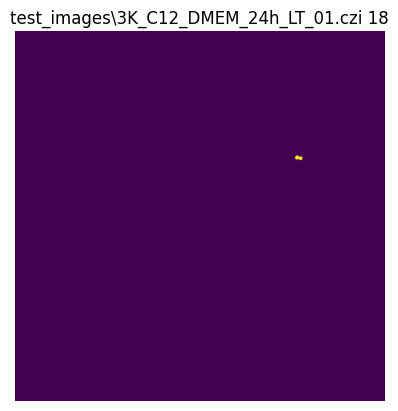

Cell 18 has 1 Red LDS


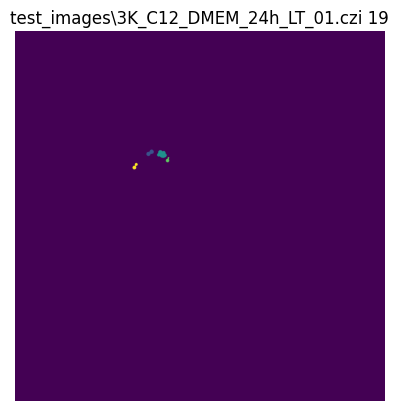

Cell 19 has 4 C12 LDS


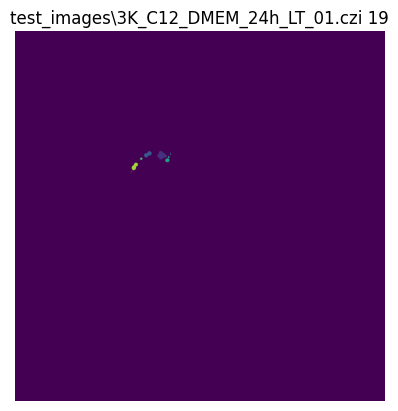

Cell 19 has 7 Red LDS
135.0 swiss inclusion in cell 26


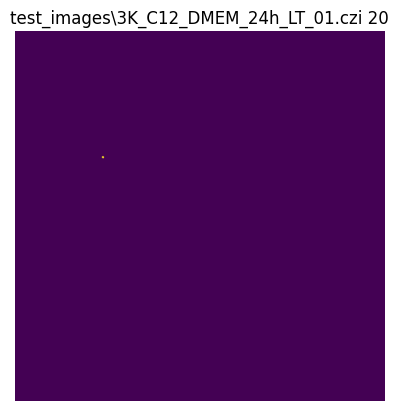

Cell 20 has 1 C12 LDS


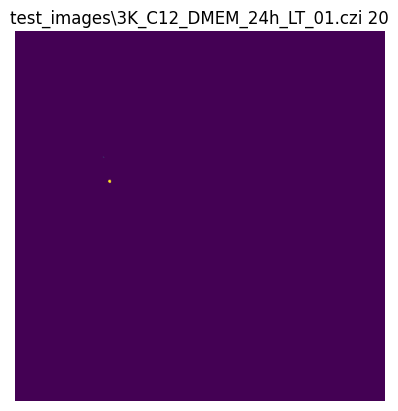

Cell 20 has 3 Red LDS


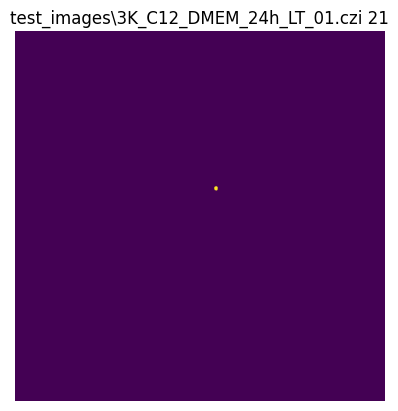

Cell 21 has 1 C12 LDS


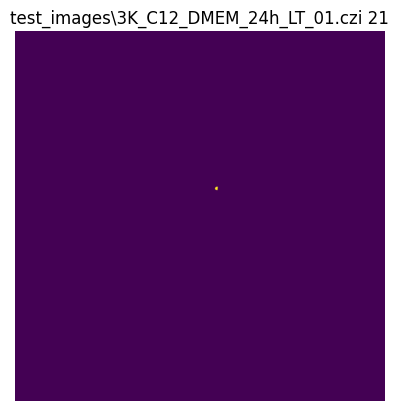

Cell 21 has 1 Red LDS


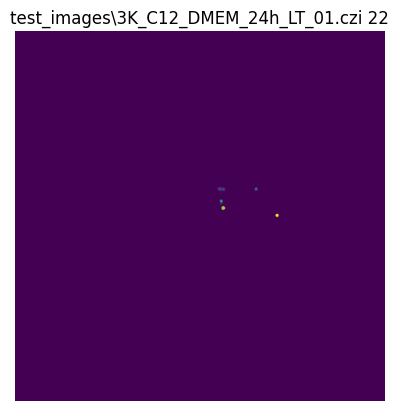

Cell 22 has 6 C12 LDS


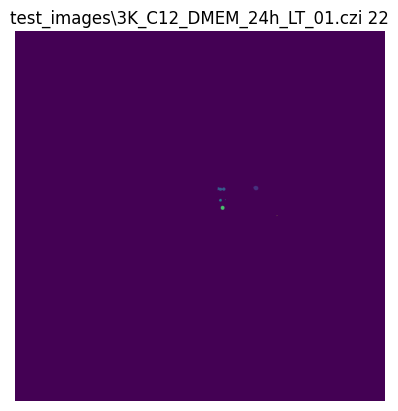

Cell 22 has 7 Red LDS


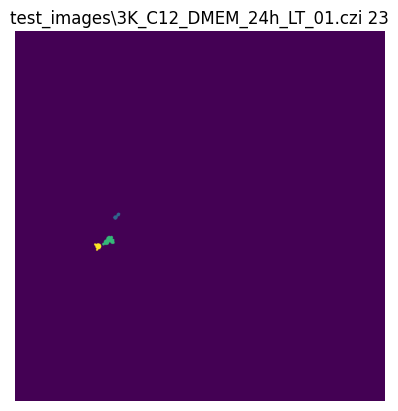

Cell 23 has 3 C12 LDS


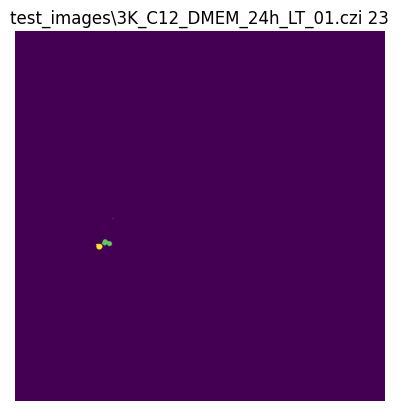

Cell 23 has 4 Red LDS


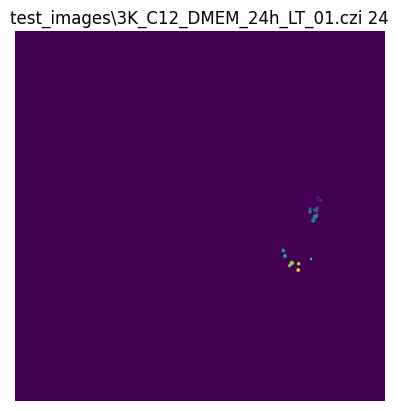

Cell 24 has 11 C12 LDS


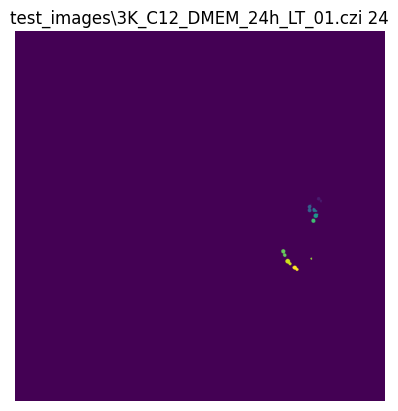

Cell 24 has 13 Red LDS


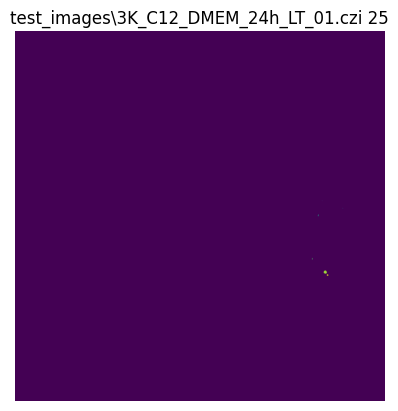

Cell 25 has 7 C12 LDS


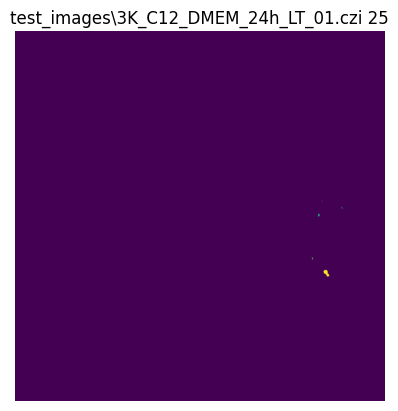

Cell 25 has 5 Red LDS


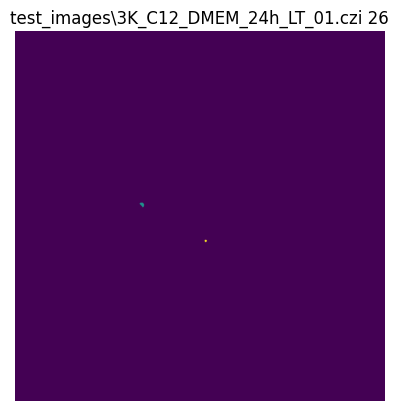

Cell 26 has 2 C12 LDS


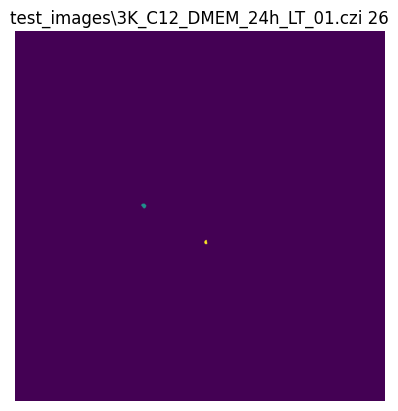

Cell 26 has 2 Red LDS


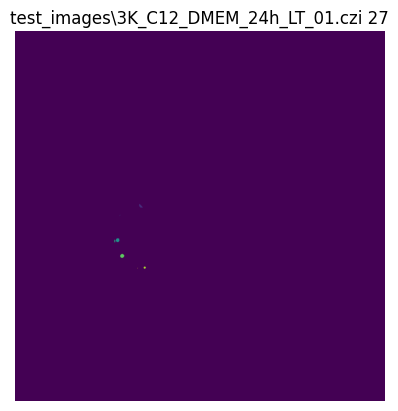

Cell 27 has 8 C12 LDS


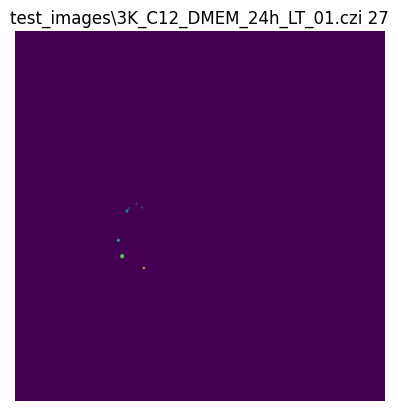

Cell 27 has 8 Red LDS
354.0 swiss inclusion in cell 34


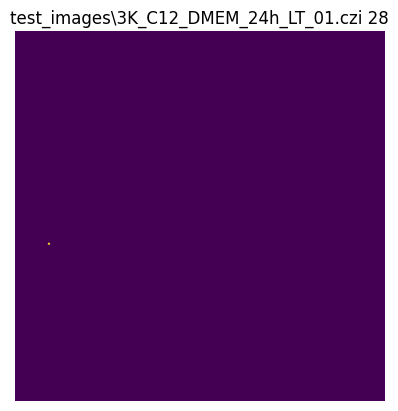

Cell 28 has 1 Red LDS


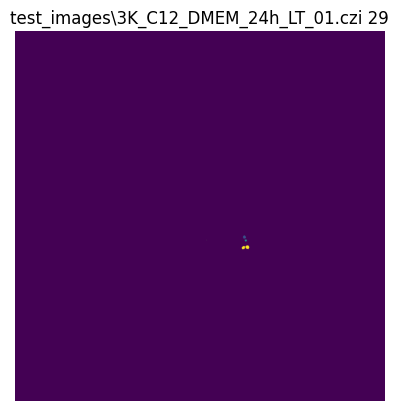

Cell 29 has 4 C12 LDS


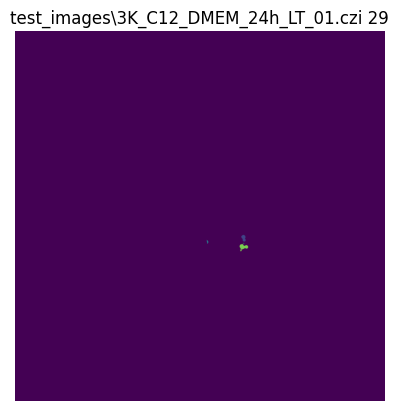

Cell 29 has 5 Red LDS


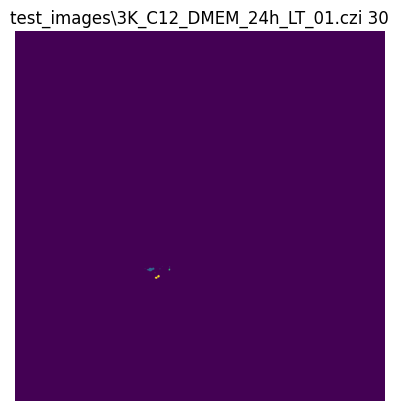

Cell 30 has 9 C12 LDS


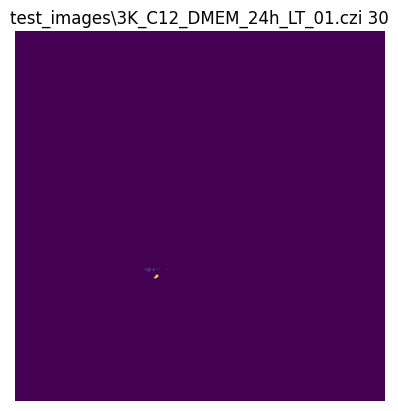

Cell 30 has 8 Red LDS


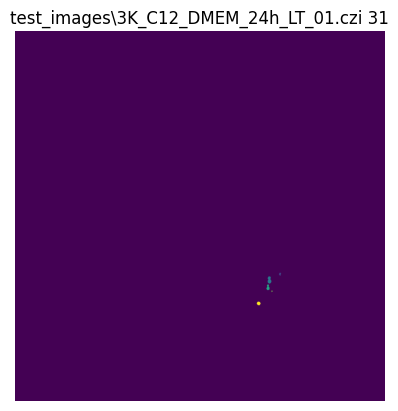

Cell 31 has 5 C12 LDS


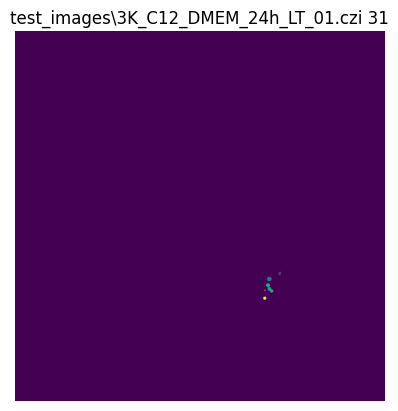

Cell 31 has 5 Red LDS


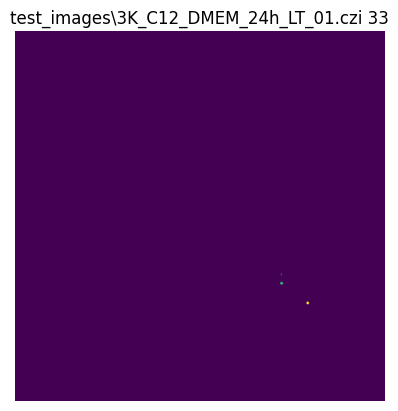

Cell 33 has 3 C12 LDS


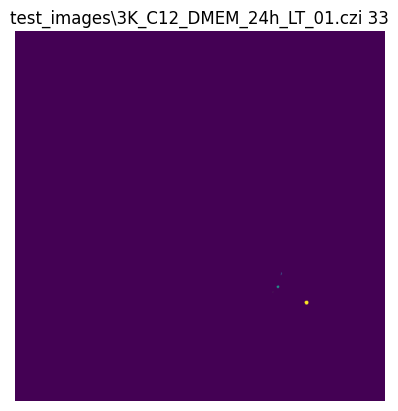

Cell 33 has 4 Red LDS


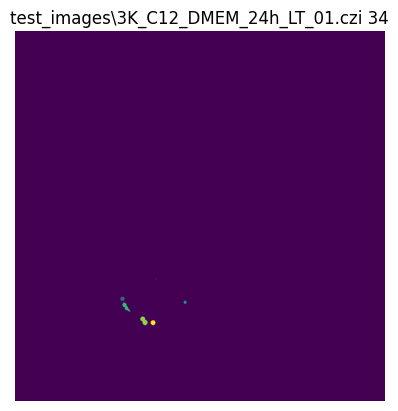

Cell 34 has 6 C12 LDS


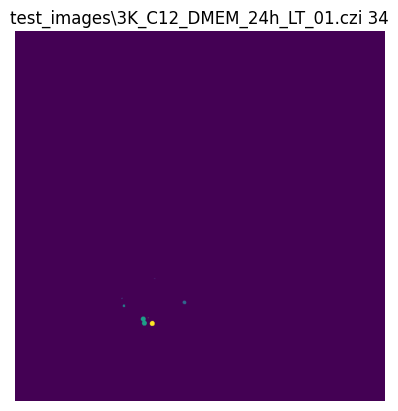

Cell 34 has 9 Red LDS


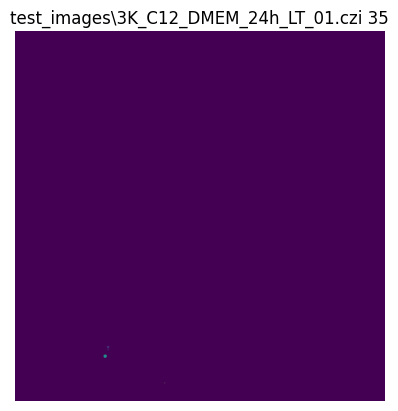

Cell 35 has 6 C12 LDS


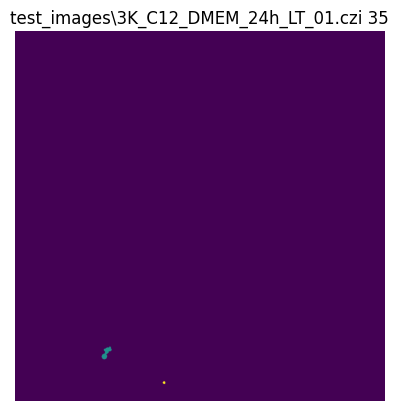

Cell 35 has 2 Red LDS


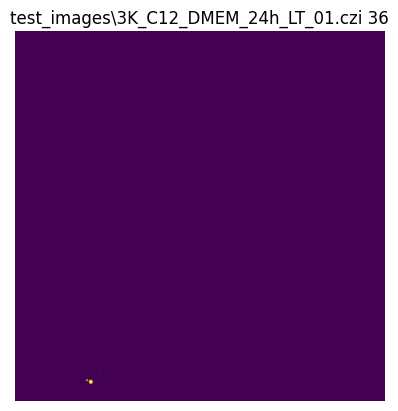

Cell 36 has 6 C12 LDS


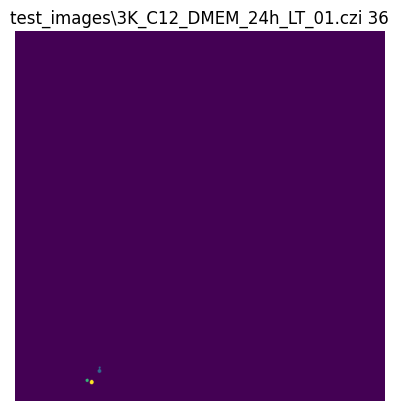

Cell 36 has 3 Red LDS


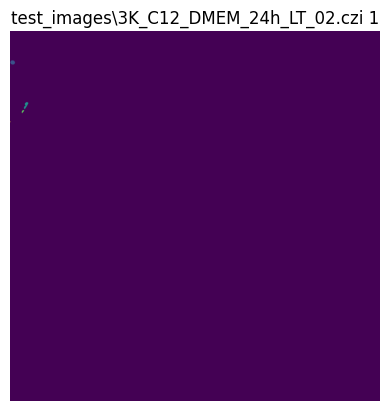

Cell 1 has 4 C12 LDS


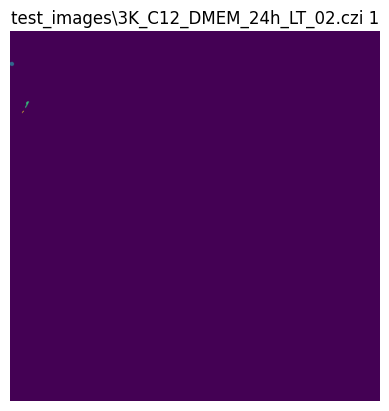

Cell 1 has 3 Red LDS


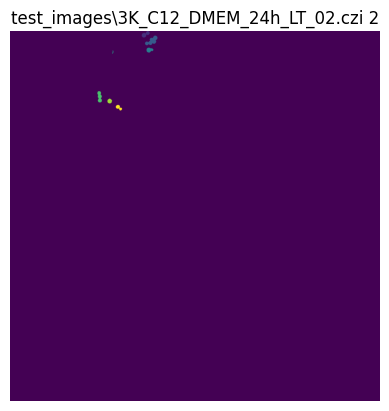

Cell 2 has 7 C12 LDS


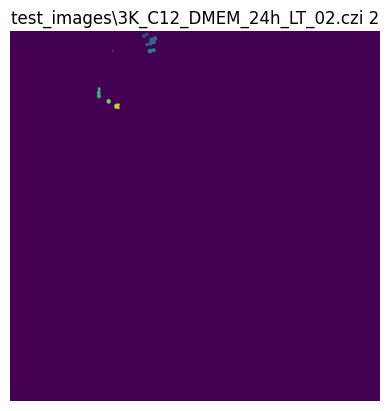

Cell 2 has 9 Red LDS


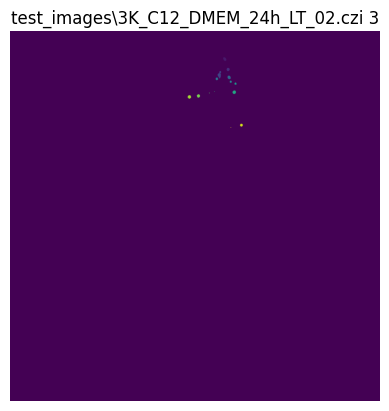

Cell 3 has 15 C12 LDS


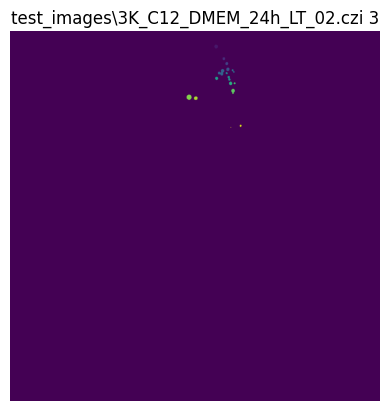

Cell 3 has 16 Red LDS


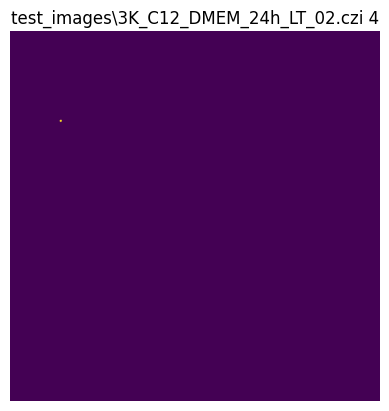

Cell 4 has 1 Red LDS


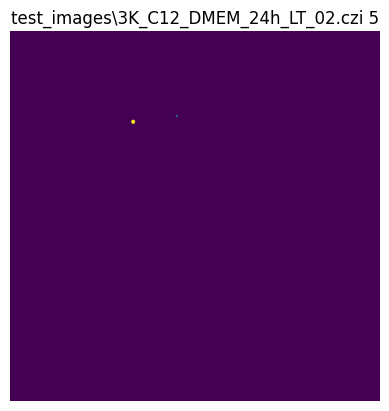

Cell 5 has 2 C12 LDS


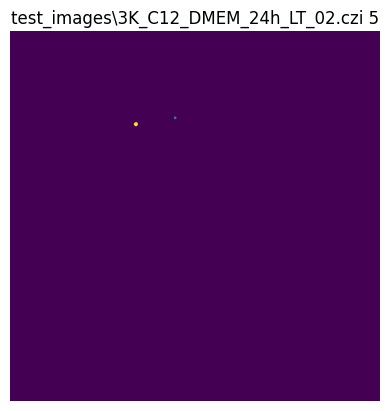

Cell 5 has 2 Red LDS


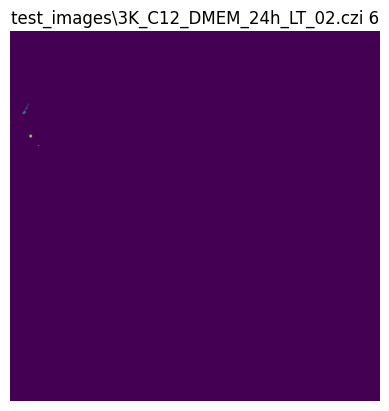

Cell 6 has 5 C12 LDS


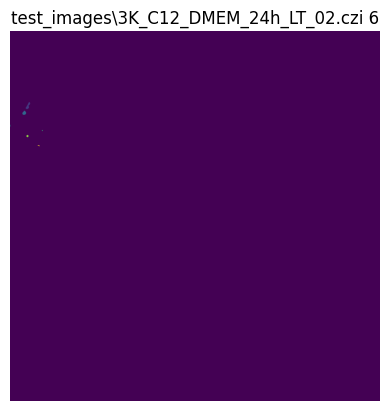

Cell 6 has 6 Red LDS


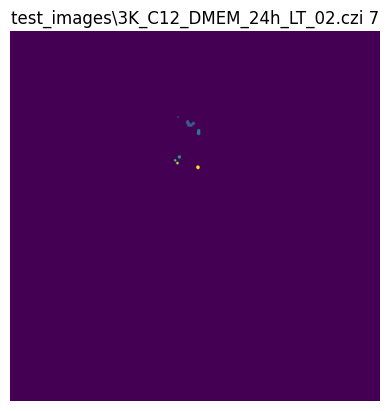

Cell 7 has 7 C12 LDS


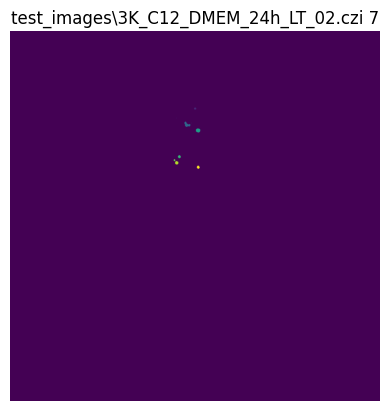

Cell 7 has 9 Red LDS
62.0 swiss inclusion in cell 7


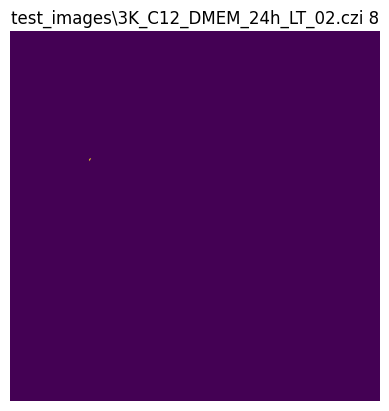

Cell 8 has 1 C12 LDS


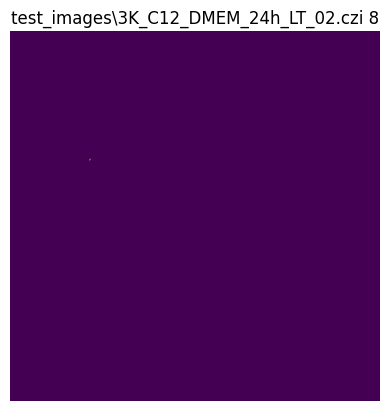

Cell 8 has 1 Red LDS


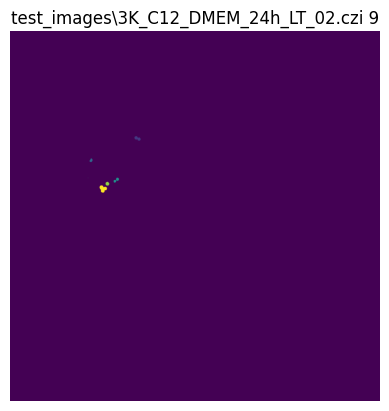

Cell 9 has 6 C12 LDS


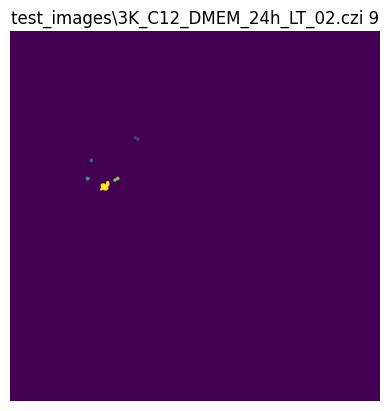

Cell 9 has 5 Red LDS


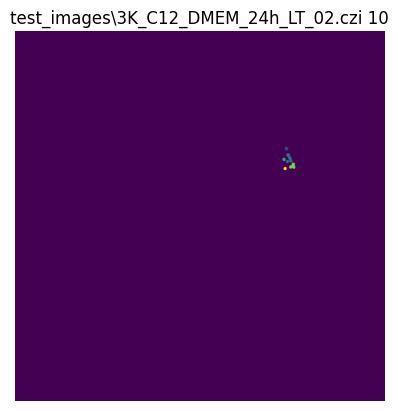

Cell 10 has 5 C12 LDS


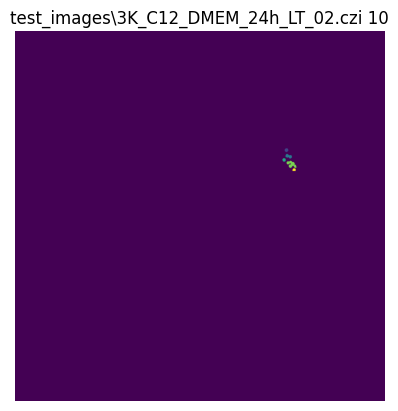

Cell 10 has 5 Red LDS


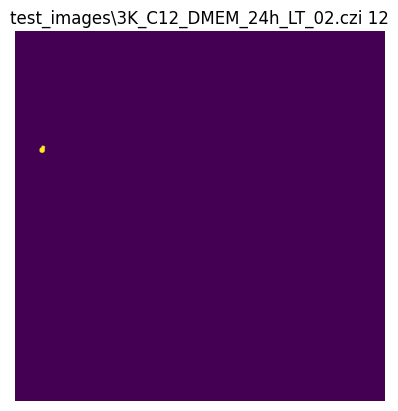

Cell 12 has 1 C12 LDS


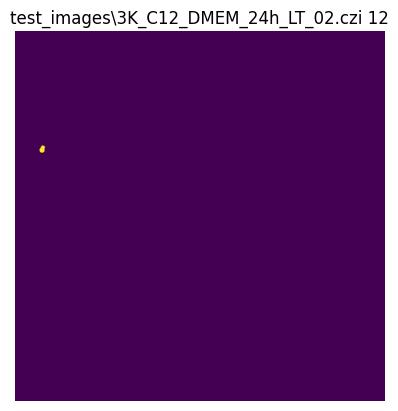

Cell 12 has 1 Red LDS


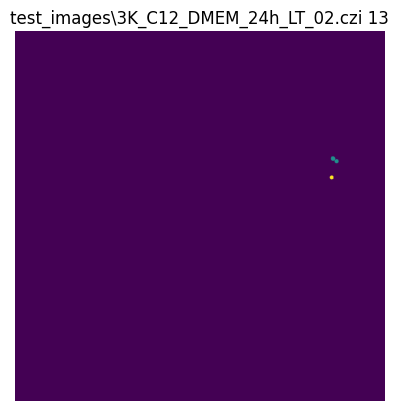

Cell 13 has 2 C12 LDS


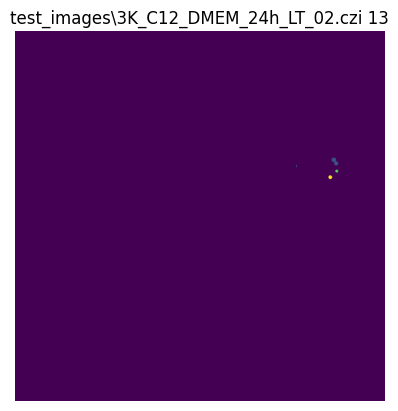

Cell 13 has 4 Red LDS


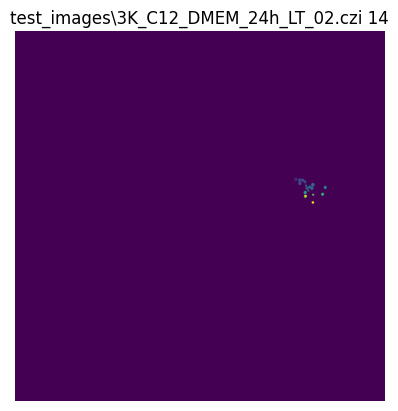

Cell 14 has 9 C12 LDS


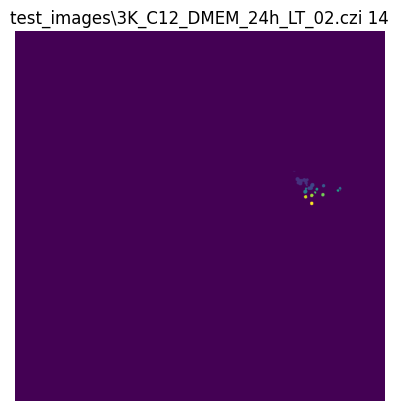

Cell 14 has 14 Red LDS
92.0 swiss inclusion in cell 15
832.0 swiss inclusion in cell 15


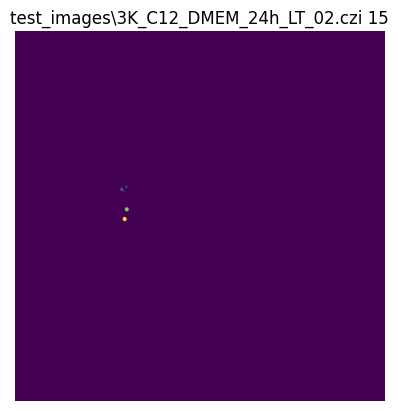

Cell 15 has 5 C12 LDS


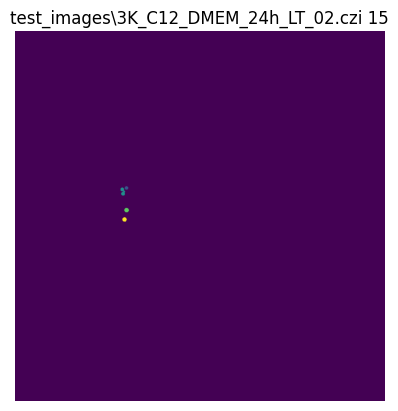

Cell 15 has 4 Red LDS
758.0 swiss inclusion in cell 16


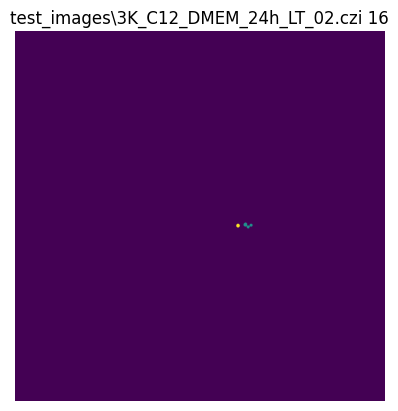

Cell 16 has 2 C12 LDS


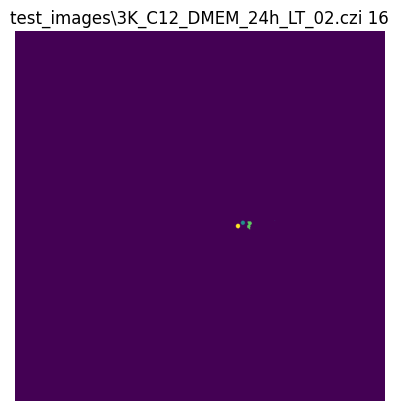

Cell 16 has 4 Red LDS
77.0 swiss inclusion in cell 18
108.0 solid inclusion in cell 18
13.0 solid inclusion in cell 18


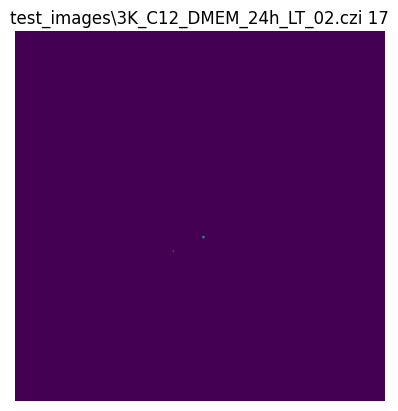

Cell 17 has 2 C12 LDS


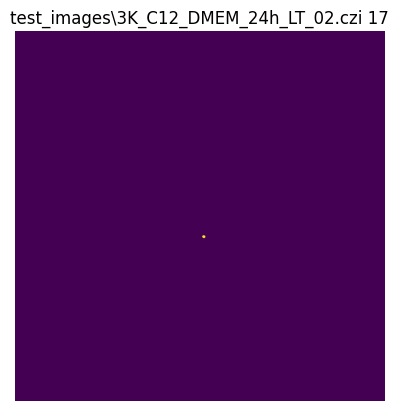

Cell 17 has 1 Red LDS
12.0 solid inclusion in cell 19


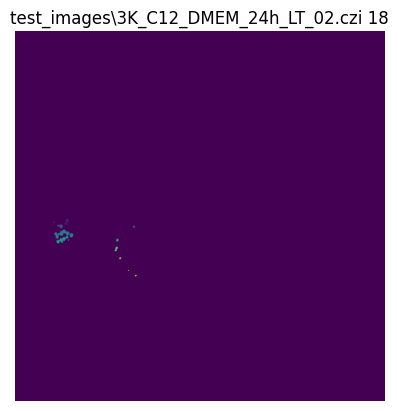

Cell 18 has 12 C12 LDS


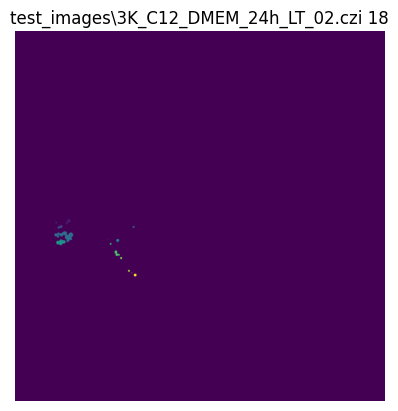

Cell 18 has 14 Red LDS


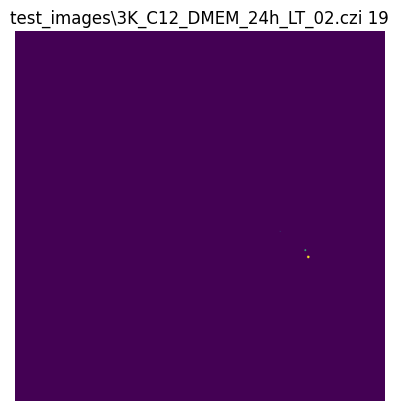

Cell 19 has 3 C12 LDS


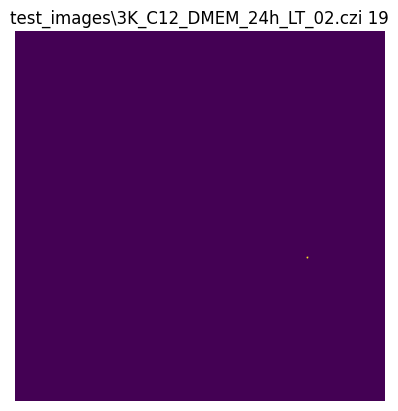

Cell 19 has 1 Red LDS


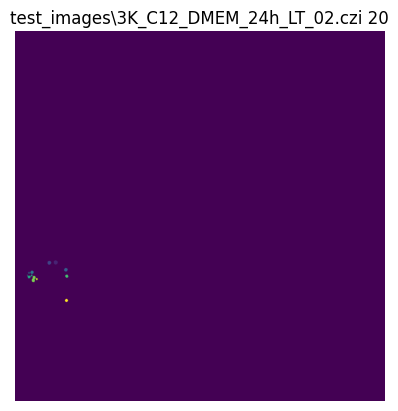

Cell 20 has 10 C12 LDS


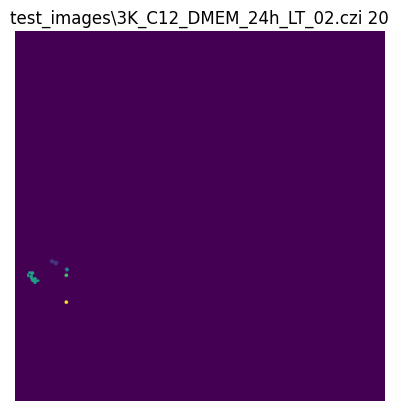

Cell 20 has 7 Red LDS


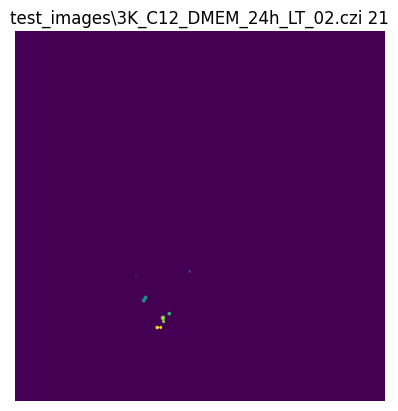

Cell 21 has 6 C12 LDS


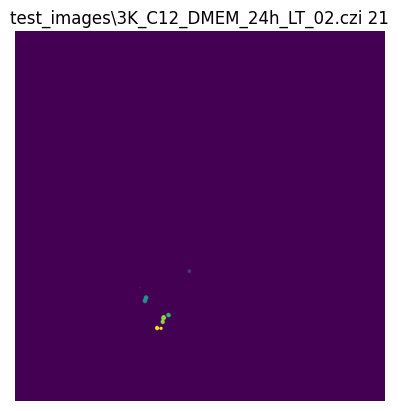

Cell 21 has 6 Red LDS


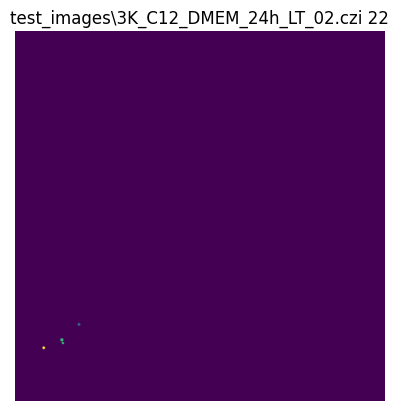

Cell 22 has 3 C12 LDS


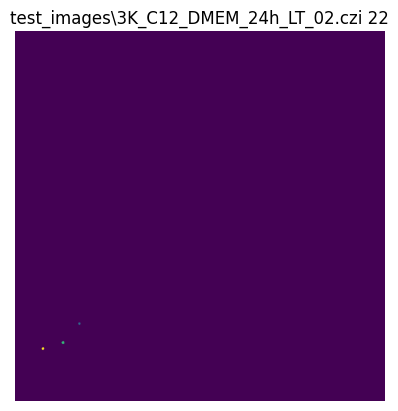

Cell 22 has 3 Red LDS


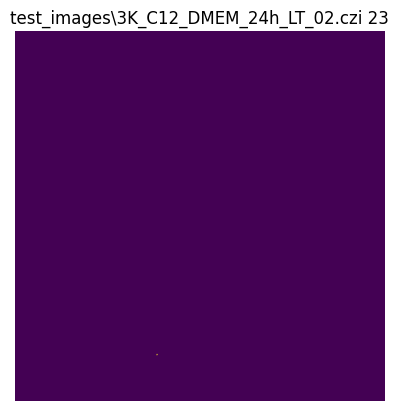

Cell 23 has 1 C12 LDS


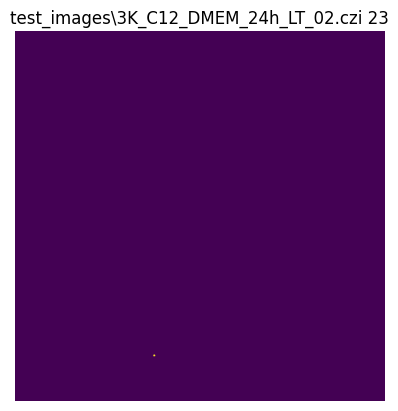

Cell 23 has 1 Red LDS
777.0 solid inclusion in cell 25


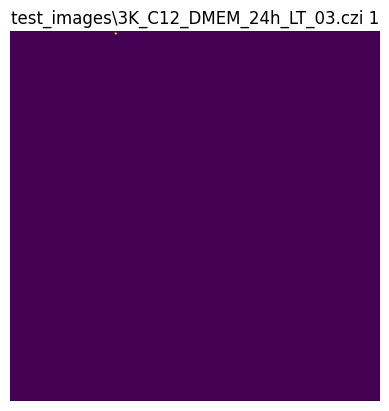

Cell 1 has 1 Red LDS


UnboundLocalError: cannot access local variable 'total_C12_LDS' where it is not associated with a value

In [9]:
def main(image_folder):

    images_to_analyze = extract_image_paths(image_folder)
    output_dir = os.getcwd()
    df_cell_summary_list = []
    # Iterate over each image
    for path in images_to_analyze:
        image = read_image(path)
        image_squeezed = np.squeeze(image) 
        deep_red, c12, green_channel = extract_channels(image_squeezed)

        c12_mask = analyze_image_c12(c12)
        deep_red_mask = analyze_image_deep_red(deep_red)

        deep_red_only_mask = deep_red_only(deep_red_mask, c12_mask)
        c12_only_mask = c12_only(deep_red_mask, c12_mask)
        #circularity_index(deep_red_mask)
        #display_image(c12_mask, path, "c12")
        #display_image(deep_red_mask, path, "deep red")
        #display_image(c12_only_mask, path, "c12 only")
        #display_image(deep_red_only_mask, path, "deep red only")

        #calculate_surface_area(c12_mask)
        #calculate_surface_area(deep_red_mask)
        #calculate_surface_area(deep_red_only_mask)
        #calculate_surface_area(c12_only_mask)
        

        df_cell_summary = cell_pose(green_channel, path, deep_red_mask, c12_mask)
        df_cell_summary_list.append(df_cell_summary)
        
    combined_cell_summary_df = pd.concat(df_cell_summary_list, ignore_index=True)
    output_summary_path = os.path.join(output_dir, 'SUMMARY.xlsx')
    combined_cell_summary_df.to_excel(output_summary_path, index=False)

if __name__ == "__main__":
    image_folder = 'test_images'
    main(image_folder)